# DualStyleGAN

Original Author: [Shuai Yang](https://github.com/williamyang1991)

Provided by: [BreezeWhite](https://github.com/BreezeWhite)

Original Github: https://github.com/williamyang1991/DualStyleGAN

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BreezeWhite/interesting-colabs/blob/main/scripts/DualStyleGAN.ipynb)

In [ ]:
#@title Setup
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!unzip ninja-linux.zip -d /usr/local/bin/
!update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

!git clone https://github.com/williamyang1991/DualStyleGAN.git
!pip install faiss-cpu

%cd DualStyleGAN
%load_ext autoreload
%autoreload 2


import os
from argparse import Namespace

import dlib
import numpy as np
import torch
from torch.nn import functional as F
from torchvision import transforms

from model.dualstylegan import DualStyleGAN
from model.sampler.icp import ICPTrainer
from model.encoder.psp import pSp
from model.encoder.align_all_parallel import align_face

def download_ckpt(fid, save_name):
  save_path = os.path.join('checkpoint', save_name)
  if os.path.exists(save_path):
    return
  os.makedirs(os.path.dirname(save_path), exist_ok=True)
  cmd = f'wget "https://docs.google.com/uc?export=download&confirm=t&id={fid}" -O checkpoint/{save_name}'
  !{cmd}


MODEL_PATHS = {
    "encoder": {"id": "1NgI4mPkboYvYw3MWcdUaQhkr0OWgs9ej", "name": "encoder.pt"},
    "cartoon-G": {"id": "1exS9cSFkg8J4keKPmq2zYQYfJYC5FkwL", "name": "generator.pt"},
    "cartoon-N": {"id": "1JSCdO0hx8Z5mi5Q5hI9HMFhLQKykFX5N", "name": "sampler.pt"},
    "cartoon-S": {"id": "1ce9v69JyW_Dtf7NhbOkfpH77bS_RK0vB", "name": "refined_exstyle_code.npy"},
    "caricature-G": {"id": "1BXfTiMlvow7LR7w8w0cNfqIl-q2z0Hgc", "name": "generator.pt"},
    "caricature-N": {"id": "1eJSoaGD7X0VbHS47YLehZayhWDSZ4L2Q", "name": "sampler.pt"},
    "caricature-S": {"id": "1-p1FMRzP_msqkjndRK_0JasTdwQKDsov", "name": "refined_exstyle_code.npy"},
    "anime-G": {"id": "1BToWH-9kEZIx2r5yFkbjoMw0642usI6y", "name": "generator.pt"},
    "anime-N": {"id": "19rLqx_s_SUdiROGnF_C6_uOiINiNZ7g2", "name": "sampler.pt"},
    "anime-S": {"id": "17-f7KtrgaQcnZysAftPogeBwz5nOWYuM", "name": "refined_exstyle_code.npy"},
    "arcane-G": {"id": "15l2O7NOUAKXikZ96XpD-4khtbRtEAg-Q", "name": "generator.pt"},
    "arcane-N": {"id": "1fa7p9ZtzV8wcasPqCYWMVFpb4BatwQHg", "name": "sampler.pt"},
    "arcane-S": {"id": "1z3Nfbir5rN4CrzatfcgQ8u-x4V44QCn1", "name": "exstyle_code.npy"},
    "comic-G": {"id": "1_t8lf9lTJLnLXrzhm7kPTSuNDdiZnyqE", "name": "generator.pt"},
    "comic-N": {"id": "1RXrJPodIn7lCzdb5BFc03kKqHEazaJ-S", "name": "sampler.pt"},
    "comic-S": {"id": "1ZfQ5quFqijvK3hO6f-YDYJMqd-UuQtU-", "name": "exstyle_code.npy"},
    "pixar-G": {"id": "1TgH7WojxiJXQfnCroSRYc7BgxvYH9i81", "name": "generator.pt"},
    "pixar-N": {"id": "18e5AoQ8js4iuck7VgI3hM_caCX5lXlH_", "name": "sampler.pt"},
    "pixar-S": {"id": "1I9mRTX2QnadSDDJIYM_ntyLrXjZoN7L-", "name": "exstyle_code.npy"},    
    "slamdunk-G": {"id": "1MGGxSCtyf9399squ3l8bl0hXkf5YWYNz", "name": "generator.pt"},
    "slamdunk-N": {"id": "1-_L7YVb48sLr_kPpOcn4dUq7Cv08WQuG", "name": "sampler.pt"},
    "slamdunk-S": {"id": "1Dgh11ZeXS2XIV2eJZAExWMjogxi_m_C8", "name": "exstyle_code.npy"},     
}
download_ckpt(MODEL_PATHS['encoder']['id'], MODEL_PATHS['encoder']['name'])

def download_ckpt_by_mode(mode):
  for postfix in ['-G', '-N', '-S']:
    key = mode + postfix
    download_ckpt(MODEL_PATHS[key]['id'], mode + '/' + MODEL_PATHS[key]['name'])


transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)

# Load generator
generator = DualStyleGAN(1024, 512, 8, 2, res_index=6)
generator.eval()

# Load encoder
model_path = 'checkpoint/encoder.pt'
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
opts['checkpoint_path'] = model_path
opts = Namespace(**opts)
opts.device = 'cuda'
encoder = pSp(opts)
encoder.eval()
encoder = encoder.to('cuda')

# Load sampler network
icptc = ICPTrainer(np.empty([0, 512*11]), 128)
icpts = ICPTrainer(np.empty([0, 512*7]), 128)


def run_face_alignment(image_path):
  model_name = 'checkpoint/shape_predictor_68_face_landmarks.dat'
  if not os.path.exists(model_name):
    !wget "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
    !mv shape_predictor_68_face_landmarks.dat.bz2 checkpoint/
    !bzip2 -dk checkpoint/shape_predictor_68_face_landmarks.dat.bz2
  predictor = dlib.shape_predictor(model_name)
  aligned_image = align_face(filepath=image_path, predictor=predictor)
  return aligned_image

def tensor_to_arr(tensor):
  if len(tensor.shape) > 3:
    tensor = tensor[0]
  return ((tensor.cpu().detach().numpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8)


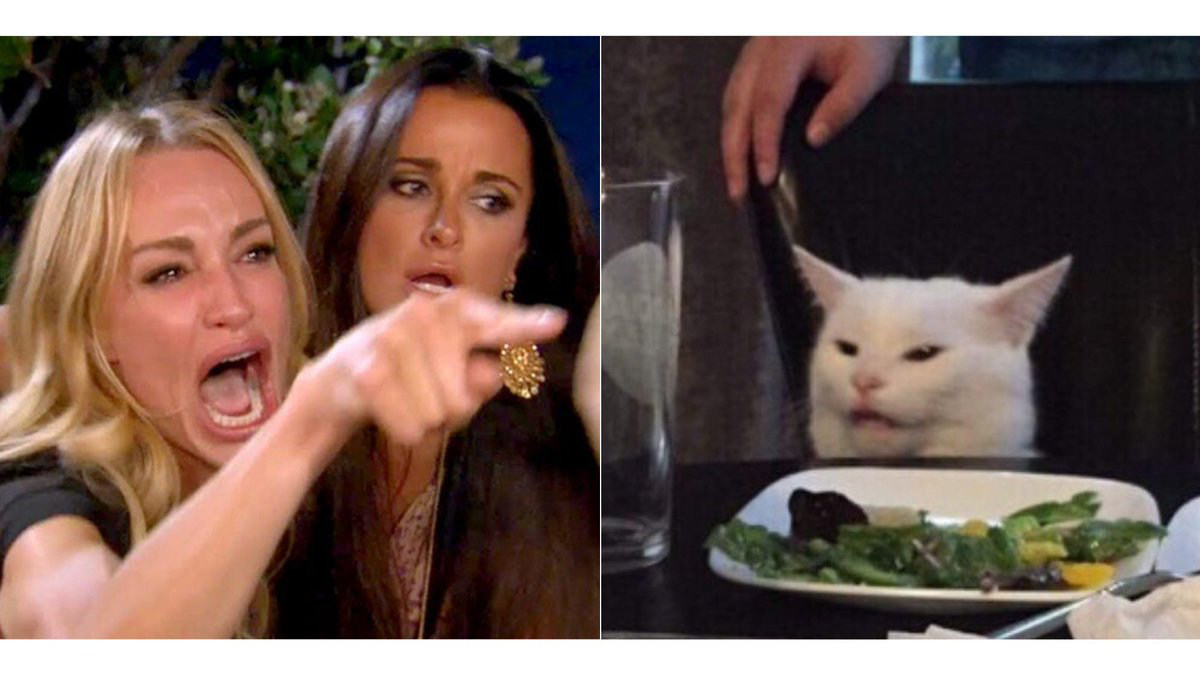

In [59]:
#@title Upload Image
from google.colab import files
from IPython.display import display, HTML
from PIL import Image

ff = files.upload()
img_name = list(ff.keys())[0]
display(Image.open(img_name))

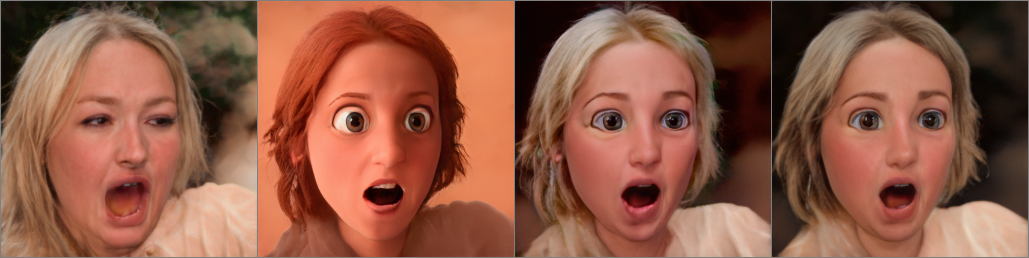

In [74]:
#@title Run

import random
import torchvision
from IPython.display import clear_output

mode = 'pixar'  #@param ['cartoon', 'caricature', 'anime', 'arcane', 'comic', 'pixar', 'slamdunk']


# Load image and transform
# feature = transform(Image.open(img_name)).unsqueeze(dim=0).to('cuda')
feature = transform(run_face_alignment(img_name)).unsqueeze(dim=0).to('cuda')

# Download checkpoints
download_ckpt_by_mode(mode)

# Load weight
ckpt = torch.load(f'checkpoint/{mode}/generator.pt', map_location=lambda storage, loc: storage)
generator.load_state_dict(ckpt["g_ema"])
generator = generator.to('cuda')

# load extrinsic style code
exstyles = np.load(f'checkpoint/{mode}/{MODEL_PATHS[mode+"-S"]["name"]}', allow_pickle='TRUE').item()

# Randomly pick the reference style
ref_style = random.choice(list(exstyles.keys()))

# load sampler network
ckpt = torch.load(f'checkpoint/{mode}/sampler.pt', map_location=lambda storage, loc: storage)
icptc.icp.netT.load_state_dict(ckpt['color'])
icpts.icp.netT.load_state_dict(ckpt['structure'])
icptc.icp.netT = icptc.icp.netT.to('cuda')
icpts.icp.netT = icpts.icp.netT.to('cuda')

with torch.no_grad():
  torch.cuda.ipc_collect()
  torch.cuda.empty_cache()
  img_rec, instyle = encoder(
    feature,
    randomize_noise=False,
    return_latents=True, 
    z_plus_latent=True,
    return_z_plus_latent=True,
    resize=False
  )
  img_rec = torch.clamp(img_rec.detach(), -1, 1)

  latent = torch.tensor(exstyles[ref_style]).repeat(2, 1, 1).to('cuda')
  latent[1, 7:18] = instyle[0, 7:18]
  exstyle = generator.generator.style(
    latent.reshape(latent.shape[0]*latent.shape[1], latent.shape[2])
  ).reshape(latent.shape)

  img_gen, _ = generator(
    [instyle.repeat(2, 1, 1)],
    exstyle,
    z_plus_latent=True, 
    truncation=0.7,
    truncation_latent=0,
    use_res=True,
    interp_weights=[0.6]*7 + [1]*11
  )
  img_gen = torch.clamp(img_gen.detach(), -1, 1)

  # Deactivate color-related layers by setting w_c = 0
  img_gen2, _ = generator(
    [instyle],
    exstyle[:1],
    z_plus_latent=True, 
    truncation=0.7,
    truncation_latent=0,
    use_res=True,
    interp_weights=[0.6]*7 + [0]*11
  )
  img_gen2 = torch.clamp(img_gen2.detach(), -1, 1)

vis = torchvision.utils.make_grid(F.adaptive_avg_pool2d(torch.cat([img_rec, img_gen, img_gen2], dim=0), 256), 4, 1)
merged = Image.fromarray(tensor_to_arr(vis))
img_rec = Image.fromarray(tensor_to_arr(img_rec))
img_gen = Image.fromarray(tensor_to_arr(img_gen))
img_gen2 = Image.fromarray(tensor_to_arr(img_gen2))
# display(HTML('<h2>Color and structure transffered</h2>'))
# display(img_rec)
# display(HTML('<h2>Color preserved A</h2>'))
# display(img_gen)
# display(HTML('<h2>Color preserved B</h2>'))
# display(img_gen2)
clear_output()
display(merged)